# Git clone GCNN library

In [1]:
# Git clone gcnn and setup lib
! git clone https://github.com/tscohen/GrouPy.git
! cp -r GrouPy/* .
! ls
! python setup.py install
! rm -rf GrouPy/

Cloning into 'GrouPy'...
remote: Enumerating objects: 221, done.
remote: Total 221 (delta 0), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (221/221), 167.17 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (112/112), done.
groupy	LICENSE      p4_fmaps.png   README.md	      sample_data
GrouPy	p4_anim.gif  p4m_fmaps.png  requirements.txt  setup.py
running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-2.7
creating build/lib.linux-x86_64-2.7/groupy
copying groupy/__init__.py -> build/lib.linux-x86_64-2.7/groupy
creating build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/garray.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/O_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/D4h_array.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib.linux-x86_64-2.7/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib.linux-x86_64-2.7/gr

# Install package 

In [2]:
! pip install imutils

  Running setup.py bdist_wheel for imutils ... - done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


# Import necessary package

In [0]:
# Import lib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import shutil
import datetime
import imutils
import csv
import platform
import math

from random import randint
from tensorflow.contrib.tensorboard.plugins import projector
from groupy.gconv.tensorflow_gconv.splitgconv2d import gconv2d, gconv2d_util

# Define global variable

If you want to run with cnn, change MODEL_TYPE to cnn. If not, change MODEL_TYPE to gcnn.

In [0]:
# Record gcnn accuracy and the best model path
gcnn_a = []
best_gcnn_model_path = ''

# Record cnn accuracy and the best model path
cnn_a = []
best_cnn_model_path = ''

In [0]:
# Define global variable
MODEL_TYPE = 'cnn'

# Initail model folder and some global variable
model_path = ''

if MODEL_TYPE == 'cnn':
    model_path = './model-densenet-cnn'
    cnn_a = []
    best_cnn_model_path = ''
else:
    model_path = './model-densenet-gcnn'
    gcnn_a = []
    best_gcnn_model_path = ''

shutil.rmtree(model_path, ignore_errors=True)
os.makedirs(model_path)

In [0]:
# Define static variable
IMG_SIZE_HEIGHT = 32
IMG_SIZE_WIDTH = 32
NUM_CLASSES = 100
INIT_LEARNING_RATE = 0.02
CHANGE_IN_LEARNING_RATE = 0.5
NUM_STEPS = 1000
DISPLAY_STEPS = 200
NUM_LAYER = 12
NUM_OF_EPOCH = 2
OVER_BEST_EPOCH_LIMIT = 2
BATCH_SIZE = 256
TESTING_BATCH_SIZE = 2000

# Define placeholder
features_placeholder = tf.placeholder(tf.float32, [None, IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3],
                                      name='features_placeholder')
labels_placeholder = tf.placeholder(tf.int32, [None,], name='labels_placeholder')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Define label dict

In [0]:
# Labels array
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

# Get training and testing data

In [8]:
# Invoke the above function to get our data.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# labels need to flatten (50000, 1) to (50000,)
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

# In gcnn, 10000 testing size is too large that cause gpu resource error
# Due to GPU resource, separate several batch
split_factor = int(math.ceil(float(test_labels.size) / TESTING_BATCH_SIZE))
test_images_batch = np.array(np.array_split(test_images, split_factor))
test_labels_batch = np.array(np.array_split(test_labels, split_factor))

169017344/169001437 [==============================] - 24s 0us/step


# Print data and label data

In [9]:
print 'Train images shape: {}'.format(train_images.shape)
print 'First train image data: \n{}\n'.format(train_images[0])

print 'Train labels shape: {}'.format(train_labels.shape)
print 'First train label data: \n{}\n'.format(train_labels[0])

print 'Test images shape: {}'.format(test_images.shape)
print 'First test image data: \n{}\n'.format(test_images[0])

print 'Test labels shape: {}'.format(test_labels.shape)
print 'First test label data: \n{}\n'.format(test_labels[0])

Train images shape: (50000, 32, 32, 3)
First train image data: 
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [195 205 193]
  [212 224 204]
  [182 194 167]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [170 176 150]
  [161 168 130]
  [146 154 113]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [189 199 169]
  [166 178 130]
  [121 133  87]]

 ...

 [[148 185  79]
  [142 182  57]
  [140 179  60]
  ...
  [ 30  17   1]
  [ 65  62  15]
  [ 76  77  20]]

 [[122 157  66]
  [120 155  58]
  [126 160  71]
  ...
  [ 22  16   3]
  [ 97 112  56]
  [141 161  87]]

 [[ 87 122  41]
  [ 88 122  39]
  [101 134  56]
  ...
  [ 34  36  10]
  [105 133  59]
  [138 173  79]]]

Train labels shape: (50000,)
First train label data: 
19

Test images shape: (10000, 32, 32, 3)
First test image data: 
[[[199 215 249]
  [196 211 244]
  [195 210 243]
  ...
  [216 231 250]
  [217 231 250]
  [224 234 252]]

 [[197 210 239]
  [195 208 238]
  [195 210 240]
  ...
  [231 243 250]
  [233 243 

# Nomalize all the data between 0 - 1

In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# Try to print some images

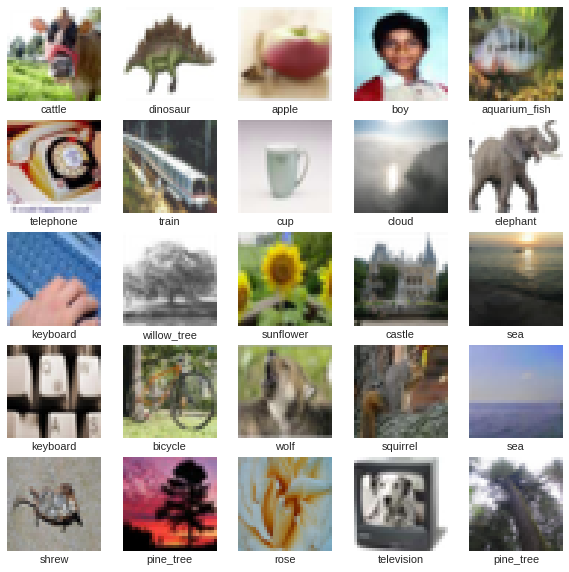

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[int(train_labels[i])])

# Get mini batch

In [0]:
def next_batch(start_index, end_index, idx):

    if end_index > train_labels.size:
        pro_idx = np.arange(0, train_labels.size)
        np.random.shuffle(pro_idx)
        idx = np.concatenate((idx,pro_idx))  
        
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        
        # remove end_index of idx
        idx = pro_idx
        
        return train_features_shuffle, train_labels_shuffle, True, idx
    else:
        train_features_shuffle, train_labels_shuffle = extract_mini_batch(start_index, end_index, idx)
        return train_features_shuffle, train_labels_shuffle, False, idx
  
  
def extract_mini_batch(start_index, end_index, idx):
  
    # Extract batch size of features and labels by idx
    train_features_shuffle = [train_images[idx[i]] for i in range(start_index,end_index)]
    train_labels_shuffle = [train_labels[idx[i]] for i in range(start_index,end_index)]
    
    # Change the array to np array
    train_features_shuffle = np.array(train_features_shuffle)
    train_labels_shuffle = np.array(train_labels_shuffle)
    
    return train_features_shuffle, train_labels_shuffle


# Denfine cnn, pooling, gcnn, batch nomlization method

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

  
def channels(x):
    return int(x.get_shape()[-1])

  
def batch_normalization(x):
    print "Batch Norm"
    eps = 1e-5
    gamma = tf.Variable(tf.constant(1.0, shape=[channels(x)]))
    beta = tf.Variable(tf.constant(0.0, shape=[channels(x)]))
    mean, variance = tf.nn.moments(x, [0, 1, 2], keep_dims=False)
    return tf.nn.batch_normalization(x, mean, variance, beta, gamma, eps)
  
  
def tf_conv2d_layer(features, num_filters, filter_size, strides, padding, BN = True):
    
    # Define filter size and strides
    filter_height, filter_width = filter_size
    stride_height, stride_width = strides

    # Create weight and bias variable
    weight = weight_variable([filter_height, filter_width, features.get_shape().as_list()[3], num_filters])
    bias = bias_variable([num_filters])
    # tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    conv = tf.nn.conv2d(features, weight, strides=[1, stride_height, stride_width, 1], padding=padding)

    # Add bias
    y = tf.nn.bias_add(conv, bias)
    
    if BN:
        # Batch normalization before activation function
        y = batch_normalization(y)
    else:
        print("no bn")
    

    # Reture a non-linear conv layer
    return tf.nn.relu(y)


def tf_gconv2d_layer(features, channels_in_out, filter_size, strides, padding, h_in_out):

    # Define filter size and strides
    h_input, h_output = h_in_out
    in_channels, out_channels = channels_in_out
    stride_height, stride_width = strides

    gconv_indices, gconv_shape_info, w_shape = gconv2d_util(
        h_input=h_input, h_output=h_output, in_channels=in_channels, out_channels=out_channels, ksize=filter_size)

    # Create weight and bias variable
    weight = weight_variable(w_shape)
    # tf.add_to_collection('loss', weight)

    # Create conv layer NWHC
    gconv = gconv2d(input=features, filter=weight, strides=[1, stride_height, stride_width, 1], padding=padding,
                gconv_indices=gconv_indices, gconv_shape_info=gconv_shape_info)

    # Add bias
    bias = bias_variable([gconv.get_shape().as_list()[3]])
    y = tf.nn.bias_add(gconv, bias)
    
    # Batch normalization before activation function
    y = batch_normalization(y)
    
    # Reture a non-linear conv layer
    return tf.nn.relu(y)


def tf_avg_pool2d_layer(features, pool_size, strides, padding):
    
    # Define pooling size
    pool_height, pool_width = pool_size
    stride_height, stride_width = strides

    # Create max pool layer
    avg_pool_layer = tf.nn.avg_pool(
        features,
        ksize=[1, pool_height, pool_width, 1],
        strides=[1, stride_height, stride_width, 1],
        padding=padding)

    return avg_pool_layer


def tf_dense_layer(features, units, activation=None):
    # Create weight and bias variable
    weight = weight_variable([features.get_shape().as_list()[1], units])
    bias = bias_variable([units])
    tf.add_to_collection('loss', weight)

    y = tf.nn.bias_add(tf.matmul(features, weight), bias)

    if activation == 'relu':
        return tf.nn.relu(y)
    elif activation == 'softmax':
        return tf.nn.softmax(y)
    else:
        return y

# Define densenet layer method

In [0]:
def add_layer(l, block_index, index_layer, g='Z2'):
    
    shape = l.get_shape().as_list()
    in_channel = shape[3]
    
    if g == 'C4':
        c = tf_gconv2d_layer(
            features=l,
            channels_in_out=(in_channel/4, 3),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=(g, g))
    elif g == 'D4':
        c = tf_gconv2d_layer(
            features=l,
            channels_in_out=(in_channel/8, 3),
            filter_size=3,
            strides=(1, 1),
            padding='SAME',
            h_in_out=(g, g))
    
    else:
        c = tf_conv2d_layer(
            features=l,
            num_filters=12,
            filter_size=(3,3),
            strides=(1,1),
            padding='SAME')
    
    l = tf.concat([c, l], 3)
    print '{}-layer{}: {}'.format(block_index, index_layer, l.get_shape())
    
    return l


def add_transition(l, block_index):
  
    shape = l.get_shape().as_list()
    in_channel = shape[3]

    l = tf_conv2d_layer(
            features=l,
            num_filters=in_channel,
            filter_size=(1,1),
            strides=(1,1),
            padding='SAME',
            BN = False)
    
    l = tf_avg_pool2d_layer(
            features=l,
            pool_size=(2,2),
            strides=(2,2),
            padding='VALID')
    
    print '{}: {}'.format(block_index, l.get_shape())
   
    return l

# Densenet structure

In [0]:
def conv_net(features, n_classes):

    if MODEL_TYPE == 'gcnn':
        
        # Define gcnn densenet
        with tf.name_scope("layer1"):
            l = tf_gconv2d_layer(
                features=tf.convert_to_tensor(features),
                channels_in_out=(3, 16),
                filter_size=7,
                strides=(1, 1),
                padding='SAME',
                h_in_out=('Z2', 'D4'))
            l = tf_avg_pool2d_layer(
                features=l,
                pool_size=(3,3),
                strides=(2,2),
                padding='VALID')
            print 'layer 1: {}\n'.format(l.get_shape())


        with tf.name_scope("block1"):
            print '=========Block 1=========='

            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block1', i, g='D4')

            l = add_transition(l, 'block1 trans layer')
            print '\n'


        with tf.name_scope("block2"):
            print '=========Block 2=========='

            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block2', i, g='D4')

            l = add_transition(l, 'block2 trans layer')
            print '\n'


        with tf.name_scope("block3"):
            print '=========Block 3=========='
            
            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block3', i, g='D4')
            print '\n'


        with tf.name_scope("flatten"):
            print '=========Fully Connected========'
            l = tf.reduce_mean(l, [1, 2])

            shape = l.get_shape().as_list()[1:]
            if None not in shape:
                l = tf.reshape(l, [-1, int(np.prod(shape))])
            else:
                l = tf.reshape(l, tf.stack([tf.shape(x)[0], -1]))

            print 'Flatten layer : {}'.format(l.get_shape())


        # Go to fully connected layer
        with tf.name_scope("dense"):
            l = tf_dense_layer(
                features=l,
                units=NUM_CLASSES)
            print 'Dense layer : {}'.format(l.get_shape())

        return l
    else :
        
        # Define cnn densenet
        with tf.name_scope("layer1"):
            l = tf_conv2d_layer(
                features=tf.convert_to_tensor(features),
                num_filters=16,
                filter_size=(7,7),
                strides=(1,1),
                padding='SAME')
            
            l = tf_avg_pool2d_layer(
                features=l,
                pool_size=(3,3),
                strides=(2,2),
                padding='VALID')
            print 'layer 1: {}\n'.format(l.get_shape())
            

        with tf.name_scope("block1"):
            print '=========Block 1=========='
            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block1', i)

            l = add_transition(l, 'block1 trans layer')
            print '\n'


        with tf.name_scope("block2"):
            print '=========Block 2=========='
            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block2', i)

            l = add_transition(l, 'block2 trans layer')
            print '\n'


        with tf.name_scope("block3"):
            print '=========Block 3=========='
            
            for i in range(NUM_LAYER): 
                l = add_layer(l, 'block3', i)
            print '\n'
            

        with tf.name_scope("flatten"):
            print '=========Fully Connected========'
            l = tf.reduce_mean(l, [1, 2])

            shape = l.get_shape().as_list()[1:]
            if None not in shape:
                l = tf.reshape(l, [-1, int(np.prod(shape))])
            else:
                l = tf.reshape(l, tf.stack([tf.shape(x)[0], -1]))

            print 'Flatten layer : {}'.format(l.get_shape())


        # Go to fully connected layer
        with tf.name_scope("dense"):
            l = tf_dense_layer(
                features=l,
                units=NUM_CLASSES)
            print 'Dense layer : {}'.format(l.get_shape())

        return l

# Training with CNN and GCNN
Remember everytime start training, please run the part of "Define global variable" to initial some record and modify the MODEL_TYPE

In [0]:
# Construct model
logits = conv_net(features_placeholder, NUM_CLASSES)

# Define loss and optimizer
with tf.name_scope("cost"):
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels_placeholder, dtype=tf.int32)))
    
    # L2
    weight_list = tf.get_collection('loss')
    total_l2_loss = 0.0
    for i in range(len(weight_list)):
        total_l2_loss += tf.nn.l2_loss(weight_list[i])
      
    loss_l2 = loss_op + 0.001 * total_l2_loss
    
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_l2,
                                  global_step=tf.train.get_global_step())

# Contruct prediction model for evaluation
with tf.name_scope("accuracy"):
    prediction = tf.nn.softmax(logits, name='prediction')
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.cast(labels_placeholder, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(tf.global_variables_initializer())
    
    # For future retore the model (Session bundle) to predict image
    saver = tf.train.Saver()

    # Start time
    start_ts = datetime.datetime.now()
    
    # For early stopping
    best_loss = float('inf')
    
    epoch_learning_rate = INIT_LEARNING_RATE
    for epoch in range(NUM_OF_EPOCH):
        
        epoch_learning_rate *= CHANGE_IN_LEARNING_RATE
        print '\n==============Epoch {} start (learning rate: {})================'.format(epoch, epoch_learning_rate)
        
        step_loss = 0.0
        start_index = 0
        end_index = start_index + BATCH_SIZE
        idx = np.arange(0 , train_labels.size)
        np.random.shuffle(idx)
    
        for step in range(1, NUM_STEPS + 1):

            train_features_shuffle, train_labels_shuffle, reset, idx_new = next_batch(
                start_index,
                end_index,
                idx)
          
            idx = idx_new
            if reset:
                start_index = 0
                end_index = start_index + BATCH_SIZE
            else:
                # Increase the start and end index
                start_index += BATCH_SIZE
                end_index += BATCH_SIZE
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={
                features_placeholder: train_features_shuffle,
                labels_placeholder: train_labels_shuffle,
                learning_rate: epoch_learning_rate})

            # Every x step print the summary
            if step % DISPLAY_STEPS == 0 or step == 1:

                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy],
                                              feed_dict={features_placeholder: train_features_shuffle,
                                                         labels_placeholder: train_labels_shuffle,
                                                         learning_rate: epoch_learning_rate})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc) + ", Time= " + \
                      "{}s".format((datetime.datetime.now() - start_ts).total_seconds()))


                # Calculate accuracy for cifar-10 test images
                total_test_accuracy = 0.0
                
                for i in range(split_factor):
                  total_test_accuracy += sess.run(accuracy, feed_dict={features_placeholder: test_images_batch[i],
                                                      labels_placeholder: test_labels_batch[i],
                                                      learning_rate: epoch_learning_rate})
                test_acc = total_test_accuracy/split_factor
                print "Testing Accuracy: {}".format(test_acc)               

                # Record each display accuracy for plot graph
                if not (epoch == 0 and step == 1):
                    if MODEL_TYPE == 'cnn':
                        cnn_a.append(test_acc)
                    else:
                        gcnn_a.append(test_acc)

                start_ts = datetime.datetime.now()
                
                # Training early stop 
                if loss < best_loss:
                  
                    # We can restore the varable to check the content
                    save_path = saver.save(sess, model_path + '/model/epoch-' + str(epoch))
                    print("Model saved in file: {}, Step: {}".format(save_path, step))
                    
                    best_loss = loss
                    best_epoch = epoch
                    
                    if MODEL_TYPE == 'cnn':
                        best_cnn_model_path = save_path
                    else:
                        best_gcnn_model_path = save_path
                
                print '\n'
    print 'Finish training!'

# Training log of CNN

Batch Norm

layer 1: (?, 15, 15, 16)

<br>

=========Block 1==========

Batch Norm

block1-layer0: (?, 15, 15, 28)

Batch Norm

block1-layer1: (?, 15, 15, 40)

Batch Norm

block1-layer2: (?, 15, 15, 52)

Batch Norm

block1-layer3: (?, 15, 15, 64)

Batch Norm

block1-layer4: (?, 15, 15, 76)

Batch Norm

block1-layer5: (?, 15, 15, 88)

Batch Norm

block1-layer6: (?, 15, 15, 100)

Batch Norm

block1-layer7: (?, 15, 15, 112)

Batch Norm

block1-layer8: (?, 15, 15, 124)

Batch Norm

block1-layer9: (?, 15, 15, 136)

Batch Norm

block1-layer10: (?, 15, 15, 148)

Batch Norm

block1-layer11: (?, 15, 15, 160)

no bn

block1 trans layer: (?, 7, 7, 160)


<br>


=========Block 2==========

Batch Norm

block2-layer0: (?, 7, 7, 172)

Batch Norm

block2-layer1: (?, 7, 7, 184)

Batch Norm

block2-layer2: (?, 7, 7, 196)

Batch Norm

block2-layer3: (?, 7, 7, 208)

Batch Norm

block2-layer4: (?, 7, 7, 220)

Batch Norm

block2-layer5: (?, 7, 7, 232)

Batch Norm

block2-layer6: (?, 7, 7, 244)

Batch Norm

block2-layer7: (?, 7, 7, 256)

Batch Norm

block2-layer8: (?, 7, 7, 268)

Batch Norm

block2-layer9: (?, 7, 7, 280)

Batch Norm

block2-layer10: (?, 7, 7, 292)

Batch Norm

block2-layer11: (?, 7, 7, 304)

no bn

block2 trans layer: (?, 3, 3, 304)


<br>


=========Block 3==========

Batch Norm

block3-layer0: (?, 3, 3, 316)

Batch Norm

block3-layer1: (?, 3, 3, 328)

Batch Norm

block3-layer2: (?, 3, 3, 340)

Batch Norm

block3-layer3: (?, 3, 3, 352)

Batch Norm

block3-layer4: (?, 3, 3, 364)

Batch Norm

block3-layer5: (?, 3, 3, 376)

Batch Norm

block3-layer6: (?, 3, 3, 388)

Batch Norm

block3-layer7: (?, 3, 3, 400)

Batch Norm

block3-layer8: (?, 3, 3, 412)

Batch Norm

block3-layer9: (?, 3, 3, 424)

Batch Norm

block3-layer10: (?, 3, 3, 436)

Batch Norm

block3-layer11: (?, 3, 3, 448)


<br>


=========Fully Connected========

Flatten layer : (?, 448)

Dense layer : (?, 100)

<br>

==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 4.9988, Training Accuracy= 0.012, Time= 8.148245s
Testing Accuracy: 0.00929999984801

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 1


Step 200, Minibatch Loss= 3.0838, Training Accuracy= 0.211, Time= 56.132176s
Testing Accuracy: 0.124899999797

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 200


Step 400, Minibatch Loss= 2.2720, Training Accuracy= 0.445, Time= 55.734672s
Testing Accuracy: 0.234699997306

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 400


Step 600, Minibatch Loss= 1.6252, Training Accuracy= 0.574, Time= 55.537522s
Testing Accuracy: 0.319299995899

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 600


Step 800, Minibatch Loss= 1.2693, Training Accuracy= 0.660, Time= 56.252834s
Testing Accuracy: 0.37840000391

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 800


Step 1000, Minibatch Loss= 1.0289, Training Accuracy= 0.734, Time= 56.277135s
Testing Accuracy: 0.409900009632

Model saved in file: ./model-densenet-cnn/model/epoch-0, Step: 1000

<br>

==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 1.2497, Training Accuracy= 0.672, Time= 2.929006s
Testing Accuracy: 0.429899996519


Step 200, Minibatch Loss= 0.8694, Training Accuracy= 0.789, Time= 53.438366s
Testing Accuracy: 0.463800001144

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 200


Step 400, Minibatch Loss= 0.7001, Training Accuracy= 0.855, Time= 55.706825s
Testing Accuracy: 0.472599995136

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 400


Step 600, Minibatch Loss= 0.5730, Training Accuracy= 0.883, Time= 56.092223s
Testing Accuracy: 0.478200000525

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 600


Step 800, Minibatch Loss= 0.3254, Training Accuracy= 0.957, Time= 55.681774s
Testing Accuracy: 0.474699997902

Model saved in file: ./model-densenet-cnn/model/epoch-1, Step: 800


Step 1000, Minibatch Loss= 0.3323, Training Accuracy= 0.949, Time= 56.431099s
Testing Accuracy: 0.472799998522


Finish training!

# Training log of GCNN

Batch Norm

layer 1: (?, 15, 15, 128)

<br>

=========Block 1==========

Batch Norm

block1-layer0: (?, 15, 15, 152)

Batch Norm

block1-layer1: (?, 15, 15, 176)

Batch Norm

block1-layer2: (?, 15, 15, 200)

Batch Norm

block1-layer3: (?, 15, 15, 224)

Batch Norm

block1-layer4: (?, 15, 15, 248)

Batch Norm

block1-layer5: (?, 15, 15, 272)

Batch Norm

block1-layer6: (?, 15, 15, 296)

Batch Norm

block1-layer7: (?, 15, 15, 320)

Batch Norm

block1-layer8: (?, 15, 15, 344)

Batch Norm

block1-layer9: (?, 15, 15, 368)

Batch Norm

block1-layer10: (?, 15, 15, 392)

Batch Norm

block1-layer11: (?, 15, 15, 416)

no bn

block1 trans layer: (?, 7, 7, 416)


<br>


=========Block 2==========

Batch Norm

block2-layer0: (?, 7, 7, 440)

Batch Norm

block2-layer1: (?, 7, 7, 464)

Batch Norm

block2-layer2: (?, 7, 7, 488)

Batch Norm

block2-layer3: (?, 7, 7, 512)

Batch Norm

block2-layer4: (?, 7, 7, 536)

Batch Norm

block2-layer5: (?, 7, 7, 560)

Batch Norm

block2-layer6: (?, 7, 7, 584)

Batch Norm

block2-layer7: (?, 7, 7, 608)

Batch Norm

block2-layer8: (?, 7, 7, 632)

Batch Norm

block2-layer9: (?, 7, 7, 656)

Batch Norm

block2-layer10: (?, 7, 7, 680)

Batch Norm

block2-layer11: (?, 7, 7, 704)

no bn

block2 trans layer: (?, 3, 3, 704)


<br>


=========Block 3==========

Batch Norm

block3-layer0: (?, 3, 3, 728)

Batch Norm

block3-layer1: (?, 3, 3, 752)

Batch Norm

block3-layer2: (?, 3, 3, 776)

Batch Norm

block3-layer3: (?, 3, 3, 800)

Batch Norm

block3-layer4: (?, 3, 3, 824)

Batch Norm

block3-layer5: (?, 3, 3, 848)

Batch Norm

block3-layer6: (?, 3, 3, 872)

Batch Norm

block3-layer7: (?, 3, 3, 896)

Batch Norm

block3-layer8: (?, 3, 3, 920)

Batch Norm

block3-layer9: (?, 3, 3, 944)

Batch Norm

block3-layer10: (?, 3, 3, 968)

Batch Norm

block3-layer11: (?, 3, 3, 992)

<br>
=========Fully Connected========

Flatten layer : (?, 992)

Dense layer : (?, 100)

<br>
==============Epoch 0 start (learning rate: 0.01)================

Step 1, Minibatch Loss= 6.1702, Training Accuracy= 0.020, Time= 14.611218s
Testing Accuracy: 0.0170999998227

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 1


Step 200, Minibatch Loss= 3.0477, Training Accuracy= 0.254, Time= 130.921652s
Testing Accuracy: 0.123700000346

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 200


Step 400, Minibatch Loss= 1.7878, Training Accuracy= 0.539, Time= 131.275529s
Testing Accuracy: 0.29430000186

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 400


Step 600, Minibatch Loss= 1.2588, Training Accuracy= 0.664, Time= 131.057654s
Testing Accuracy: 0.35340000391

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 600


Step 800, Minibatch Loss= 0.9087, Training Accuracy= 0.785, Time= 132.48143s
Testing Accuracy: 0.445699995756

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 800


Step 1000, Minibatch Loss= 0.6521, Training Accuracy= 0.852, Time= 131.076941s
Testing Accuracy: 0.467099994421

Model saved in file: ./model-densenet-gcnn/model/epoch-0, Step: 1000

<br>

==============Epoch 1 start (learning rate: 0.005)================

Step 1, Minibatch Loss= 0.8912, Training Accuracy= 0.777, Time= 2.033236s
Testing Accuracy: 0.488200008869


Step 200, Minibatch Loss= 0.5110, Training Accuracy= 0.895, Time= 128.635996s
Testing Accuracy: 0.531900000572

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 200


Step 400, Minibatch Loss= 0.3739, Training Accuracy= 0.934, Time= 129.407132s
Testing Accuracy: 0.528199994564

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 400


Step 600, Minibatch Loss= 0.1989, Training Accuracy= 0.988, Time= 129.427763s
Testing Accuracy: 0.52760001421

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 600


Step 800, Minibatch Loss= 0.1729, Training Accuracy= 0.977, Time= 129.113007s
Testing Accuracy: 0.523200011253

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 800


Step 1000, Minibatch Loss= 0.1066, Training Accuracy= 0.996, Time= 129.088499s
Testing Accuracy: 0.522899997234

Model saved in file: ./model-densenet-gcnn/model/epoch-1, Step: 1000


Finish training!

# Plot cnn and gcnn accuracy graph

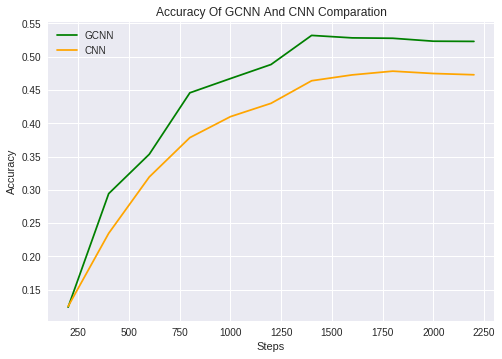

In [19]:
# This is for two type of conv have same step accuracy record 
total_record_step = (NUM_OF_EPOCH * NUM_STEPS/DISPLAY_STEPS) + (NUM_OF_EPOCH -1)
steps = []

for i in range(total_record_step):
    steps.append((i+1)*DISPLAY_STEPS)

plt.plot(steps[:len(gcnn_a)], gcnn_a, color='g')
plt.plot(steps[:len(cnn_a)], cnn_a, color='orange')

plt.legend(['GCNN', 'CNN'])

plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Of GCNN And CNN Comparation')

plt.show()


# Define extract random predict result method 

In [0]:
def extract_predict_result(num_predict_size, extract_num, part_of_test_images, part_of_test_labels, predict_result):
    idx = np.arange(0, num_predict_size)
    np.random.shuffle(idx)  
    
    # Extract batch size of features and labels by idx
    part_of_test_images = [part_of_test_images[idx[i]] for i in range(0,extract_num)]
    part_of_test_labels = [part_of_test_labels[idx[i]] for i in range(0,extract_num)]
    predict_result = [predict_result[idx[i]] for i in range(0,extract_num)]
    
    # Change the array to np array
    part_of_test_images = np.array(part_of_test_images)
    part_of_test_labels = np.array(part_of_test_labels)
    predict_result = np.array(predict_result)
    return part_of_test_images, part_of_test_labels, predict_result

# Predict with gcnn
If you run gcnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-gcnn/model/epoch-1


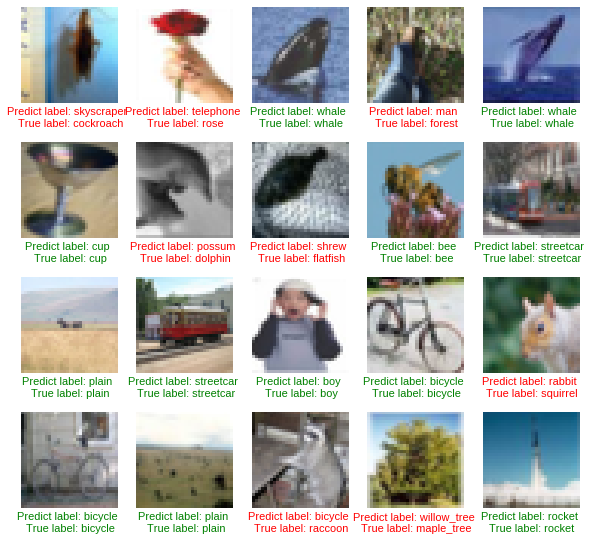

In [21]:
gcnn_graph = tf.Graph()
with tf.Session(graph=gcnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_gcnn_model_path + '.meta')
    saver.restore(sess, best_gcnn_model_path)

    graph = tf.get_default_graph()
    
    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = classes[predicted_label]
        true_class = classes[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)

    


# Predict with cnn
If you run cnn first, the predict should be "accuracy/prediction:0" not "accuracy_1/prediction:0" 

INFO:tensorflow:Restoring parameters from ./model-densenet-cnn/model/epoch-1


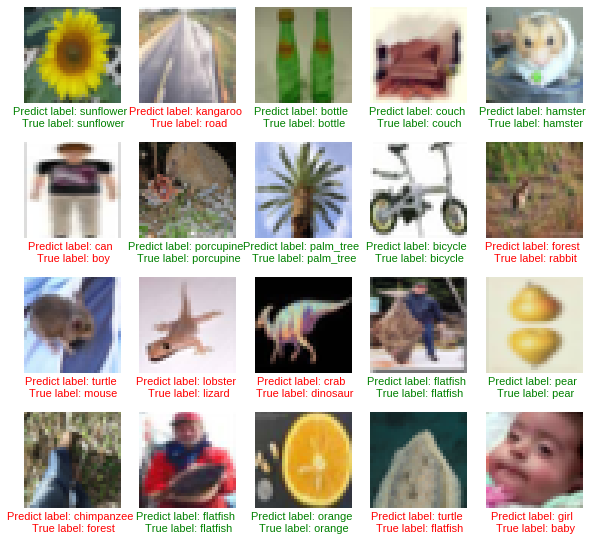

In [22]:
cnn_graph = tf.Graph()
with tf.Session(graph=cnn_graph) as sess:

    saver = tf.train.import_meta_graph(best_cnn_model_path + '.meta')
    saver.restore(sess, best_cnn_model_path)

    graph = tf.get_default_graph()

    # Extract part of test image and label to predict 
    # then random show 20 predict result 
    part_of_test_images = test_images[:256]
    part_of_test_labels = test_labels[:256]
    
    features_placeholder = graph.get_tensor_by_name("features_placeholder:0")
    feed_dict = {features_placeholder:np.array(part_of_test_images)}

    # Output node
    prediction = graph.get_tensor_by_name("accuracy_1/prediction:0")
    pred_result = sess.run(tf.argmax(prediction, 1),feed_dict)
    
    part_of_test_images, part_of_test_labels, pred_result = extract_predict_result(256, 
                                                20,
                                                part_of_test_images, 
                                                part_of_test_labels,
                                                pred_result)
    
    plt.figure(figsize=(10,12))
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid('off')

        # Predict result of the image
        predicted_label = pred_result[i]
        true_label = part_of_test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'

        # Plot predict image
        plt.imshow(part_of_test_images[i])

        predicted_class = classes[predicted_label]
        true_class = classes[true_label]
        plt.xlabel("Predict label: {} \n True label: {}".format(predicted_class, true_class),
                                color=color)